In [1]:
%pylab inline
import os
import pandas as pd
import numpy as np
import scipy.stats
RESDIR="/storage/mgymrek/ssc-denovos/denovos2/denovocalls_filtered/"
MUTEADIR="/storage/mgymrek/ssc-denovos/mutea-results/"

colors = {
    1: "gray",
    2: "red",
    3: "gold",
    4: "blue",
    5: "green",
    6: "purple"
}

# Load mutations
mut = pd.read_csv(os.path.join(RESDIR, "denovos_bylength.all_mutations_pass.tab.gz"), sep="\t")

# Load MUTEA estimates
mutea = pd.read_csv(os.path.join(MUTEADIR, "ssc_mutea_auto_scaled.bed.gz"), sep="\t",
                   names=["#chrom","pos", "end","log10mu","beta","p","stderr","nsamp","center"])

# Merge
mut = pd.merge(mut, mutea, on=["#chrom","pos"])
mut["center_bp"] = mut["center"]*mut["period"]

Populating the interactive namespace from numpy and matplotlib


0.898922087746
0.696483105113
0.794309425015
0.937548307312
0.900584795322
0.935251798561


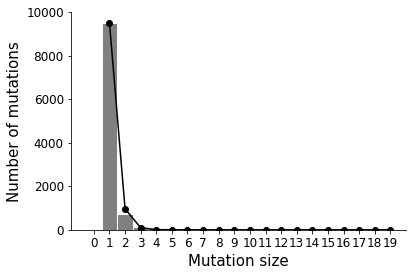

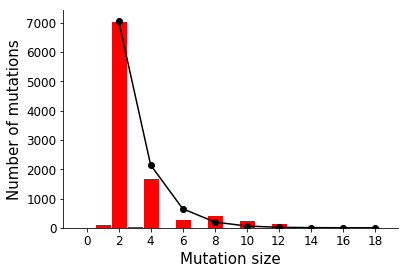

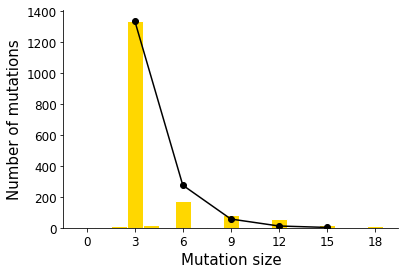

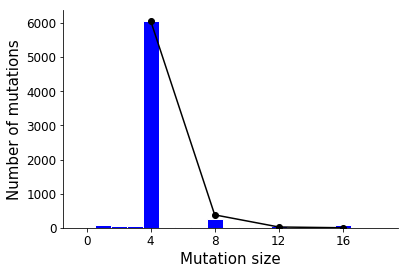

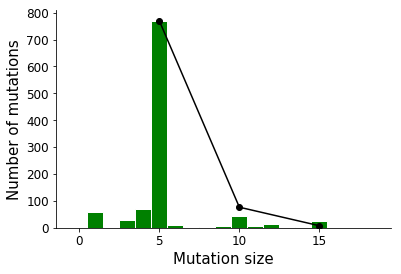

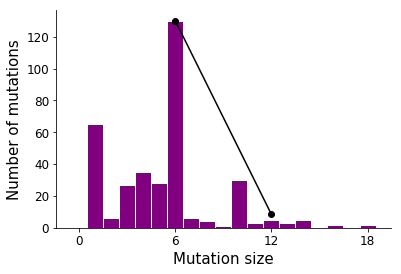

In [2]:
# For each period, plot step size distribution

def GetGeomCount(n, p, k):
    return (1-p)**(k-1)*p*n

for period in range(1, 7):
    maxallele = 20
    step_sizes = mut[(mut["period"]==period) & ~np.isnan(mut["mutsize"])]["mutsize"].apply(abs)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.hist(step_sizes, bins=np.arange(0, maxallele, 1), color=colors[period], edgecolor="white", align="left")
    ax.set_xticks(np.arange(0, maxallele, period))
    ax.set_xticklabels([int(item) for item in ax.get_xticks()], size=12)
    ax.set_yticklabels([int(item) for item in ax.get_yticks()], size=12)
    ax.set_xlabel("Mutation size", size=15)
    ax.set_ylabel("Number of mutations", size=15);
    
    # Get geometric fit for the unit ones
    step_sizes_unit = [item/period for item in step_sizes if item%period == 0] #1/np.mean(step_sizes_unit) #
    geomp = np.mean([item==1 for item in step_sizes_unit])
    print(geomp)
    xvals = [item*period for item in range(1, int(maxallele/period))]
    yvals = [GetGeomCount(len(step_sizes_unit), geomp, item/period) for item in xvals]
    ax.plot(xvals, yvals, marker="o", color="black")

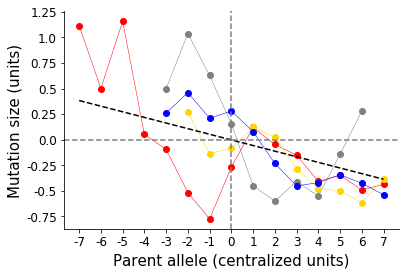

In [3]:
# For each period, plot mutation direction bias
mut["from"] = (mut["newallele"]-mut["mutsize"]-mut["center_bp"])/mut["period"]
mut["step"] = mut["mutsize"]/mut["period"]

fig = plt.figure()
ax = fig.add_subplot(111)
n = 7
fvals = np.arange(-1*n, n+1, 1)
for period in range(1, 5):
    d = mut[(mut["stderr"]>=0) & (mut["period"]==period)&(mut["mutsize"].apply(lambda x: x%period == 0))]
    stepmeans = []
    for f in fvals:
        m = np.mean(d[d["from"]==f]["step"])
        if d[d["from"]==f].shape[0] < 20:
            stepmeans.append(np.nan)
        else: stepmeans.append(m)
    ax.plot(fvals, stepmeans, color=colors[period], marker="o", linewidth=0.5)

# Get best fit line
d = mut[mut.apply(lambda x: x["mutsize"]%x["period"]==0, 1)&(mut["period"]<=4)]
xd = list(d["from"])
yd = list(d["step"])
par = np.polyfit(xd, yd, 1, full=True)
slope=par[0][0]
intercept=par[0][1]
xl = fvals
yl = [slope*xx + intercept  for xx in xl]
ax.plot(xl, yl, linestyle="dashed", color="black")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks(fvals)
ax.set_xticklabels(ax.get_xticks(), size=12);
ax.set_yticklabels(ax.get_yticks(), size=12);
ax.set_xlabel("Parent allele (centralized units)", size=15);
ax.set_ylabel("Mutation size (units)", size=15);
ax.axhline(y=0, linestyle="dashed", color="gray")
ax.axvline(x=0, linestyle="dashed", color="gray");

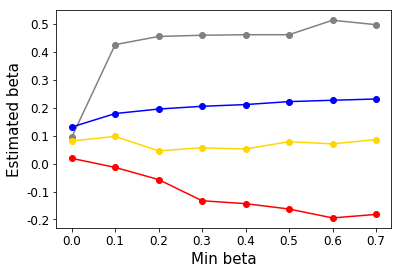

In [8]:
# How does slope change with beta?
fig = plt.figure()
ax = fig.add_subplot(111)
mut["beta_eff"] = mut.apply(lambda x: x["beta"]*(2-x["p"])/x["p"]**2, 1)
for period in range(1,5):
    betas = np.arange(0, 0.8, 0.1)
    slopes = []
    for beta in betas:
        d = mut[(mut["stderr"]>0) & (mut["period"]==period) & (mut["beta"]>beta) & (mut["mutsize"].apply(lambda x: x%period == 0))]
        xd = list(d["from"])
        yd = list(d["step"])
        par = np.polyfit(xd, yd, 1, full=True)
        slope=par[0][0]
        slopes.append(slope*-1)
    ax.plot(betas, slopes, marker="o", color=colors[period])
ax.set_xlabel("Min beta", size=15)
ax.set_ylabel("Estimated beta", size=15);
ax.set_xticklabels(ax.get_xticks(), size=12);
ax.set_yticklabels(ax.get_yticks(), size=12);

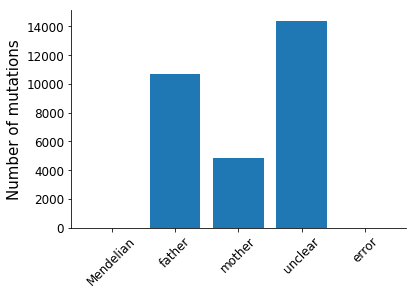

In [5]:
# Parent of origin
poocase = {
    1: "Mendelian",
    21: "father",
    2: "father",
    3: "mother",
    31: "mother",
    4: "unclear",
    41: "unclear",
    5: "error"
}
mut["poo"] = mut.apply(lambda x: poocase[x["poocase"]], 1)
mut["unit"] = mut.apply(lambda x: x["mutsize"]%x["period"]==0, 1)
categories = ["Mendelian","father","mother","unclear","error"]
counts = []
for c in categories:
    counts.append(mut[(mut["poo"]==c) & mut["unit"]].shape[0])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.bar(range(len(categories)), counts);
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories, size=12, rotation=45);
ax.set_yticklabels(map(int, ax.get_yticks()), size=12)
ax.set_ylabel("Number of mutations", size=15);

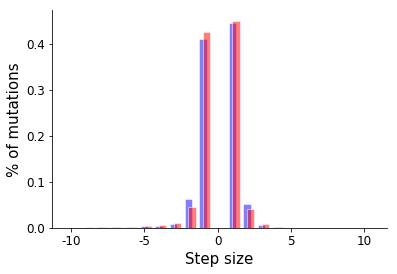

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
stepcounts_father = []
stepcounts_mother = []
steps = np.arange(-10, 11, 1)
father_total = mut[(mut["poo"]=="father") & mut["unit"]].shape[0]
mother_total = mut[(mut["poo"]=="mother") & mut["unit"]].shape[0]
for step in steps:
    stepcounts_father.append(mut[(mut["poo"]=="father")&(mut["step"]==step)& mut["unit"]].shape[0]*1.0/father_total)
    stepcounts_mother.append(mut[(mut["poo"]=="mother")&(mut["step"]==step)& mut["unit"]].shape[0]*1.0/mother_total)
ax.bar(steps, stepcounts_father, width=0.5, color="blue", edgecolor="white", alpha=0.5);
ax.bar(steps+0.25, stepcounts_mother, width=0.5, color="red", edgecolor="white", alpha=0.5);
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.set_xticklabels(map(int, ax.get_xticks()), size=12)
ax.set_xlabel("Step size", size=15);
ax.set_ylabel("% of mutations", size=15);